In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing required libraries

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle, UniformSky

import copy

from IPython.display import Image

import pylab

%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pylab

import seaborn as sns
import pandas as pd
import numpy as np

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Viewing the raw LIGO data

In [3]:
# For Single Template Model

# Storing the file name
gw170817_file_names = {}

# To store Power Spectral Density
psds = {}

# To store data
gw170817 = {}

In [4]:
merger_gw170817 = Merger("GW170817")

# LIGO Observatories
ifos = ['H1', 'V1', 'L1']

for ifo in ifos:
    
    print("Downloading: {} dataset".format(ifo))
    
    # Downloading the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"

    file_name = download_file(url.format(ifo[0], ifo[0]), cache = True)
    
    # Storing the file name
    gw170817_file_names[ifo] = file_name
    
    # Storing the data itself
    gw170817[ifo] = read_frame(file_name, "{}:LOSC-STRAIN".format(ifo), start_time = int(merger_gw170817.time - 260), end_time = int(merger_gw170817.time + 40))

Downloading: H1 dataset
Downloading: V1 dataset
Downloading: L1 dataset


## Plotting Entire 300 seconds of data around GW170817

In [5]:
def plot_gravitational_waves(ifos, gw_merger):
    
    pylab.figure(figsize = (20, 5))

    for ifo in ifos:
        pylab.plot(gw_merger[ifo].sample_times, gw_merger[ifo], label = ifo)

        pylab.ylabel('Strain')
        pylab.xlabel('GPS Time (s)')
        pylab.legend()
        
    pylab.show()

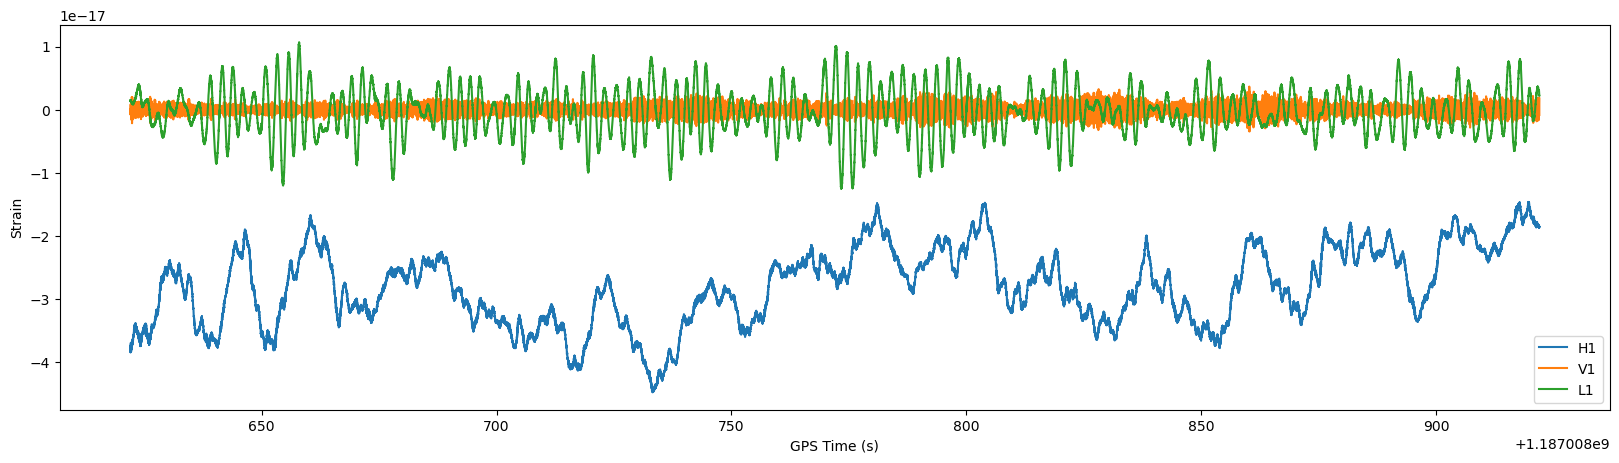

In [6]:
plot_gravitational_waves(ifos, gw170817)

# Removing low frequency content and resampling the data

**We apply highpass filter to the signal at 15Hz.<br>Applying high pass filter is used for removing low frequency content from a signal.**

**Gravitational waves have higher frequencies than most of the noise, so by filtering out low frequencies, we can enhance the signal-to-noise ratio of the gravitational wave.**

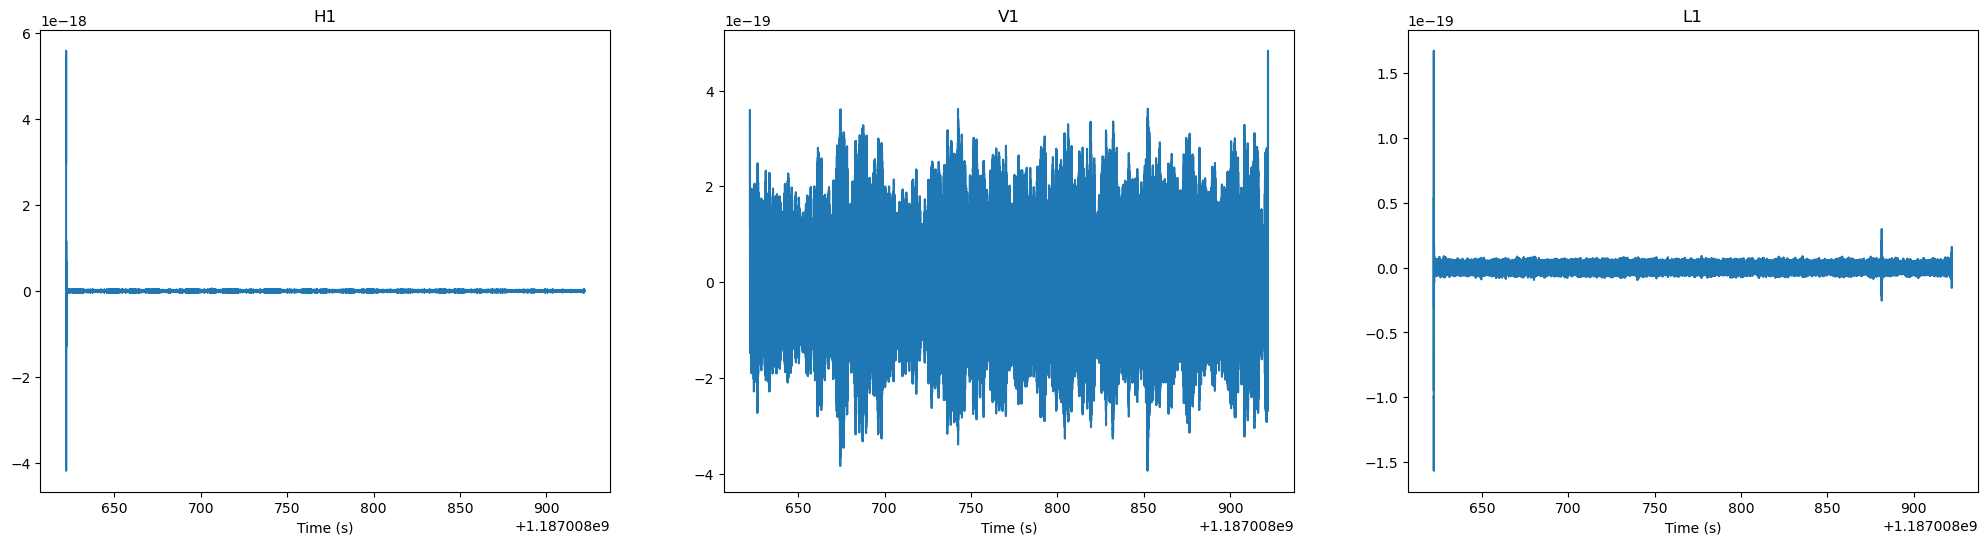

In [7]:
gw170817_highpass_resampled = {}

fig, ax = pylab.subplots(1, 3, figsize = (25, 6))

for i, ifo in zip(range(len(ifos)), ifos):
    
    # Applying HighPass Filter: Frequencies below 15Hz are removed.
    gw170817_highpass = highpass(gw170817[ifo], 15.0)
    
    # Resampling to delta_t: Used to adjust sampling rate of gravitational wave data from each detectors.
        # It makes the data from different detectors have same time step which allows us to compare data between detectors.
    gw170817_highpass_resampled[ifo] = resample_to_delta_t(gw170817_highpass, 1.0/2048)
    
    # Plotting the resampled timeseries
    ax[i].plot(gw170817_highpass_resampled[ifo].sample_times, gw170817_highpass_resampled[ifo])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_title(ifo)

pylab.show()

**The spike is caused by the high pass and resampling stages filtering of the data.<br>When the filter is applied to boundaries, it wraps around the beginning of the data.<br>Since the data has the discontinuity the filter itself will ring off for a time up to the length of the filter.**

**To avoid it we can crop 2 seconds of data from both the beginning and the end.**

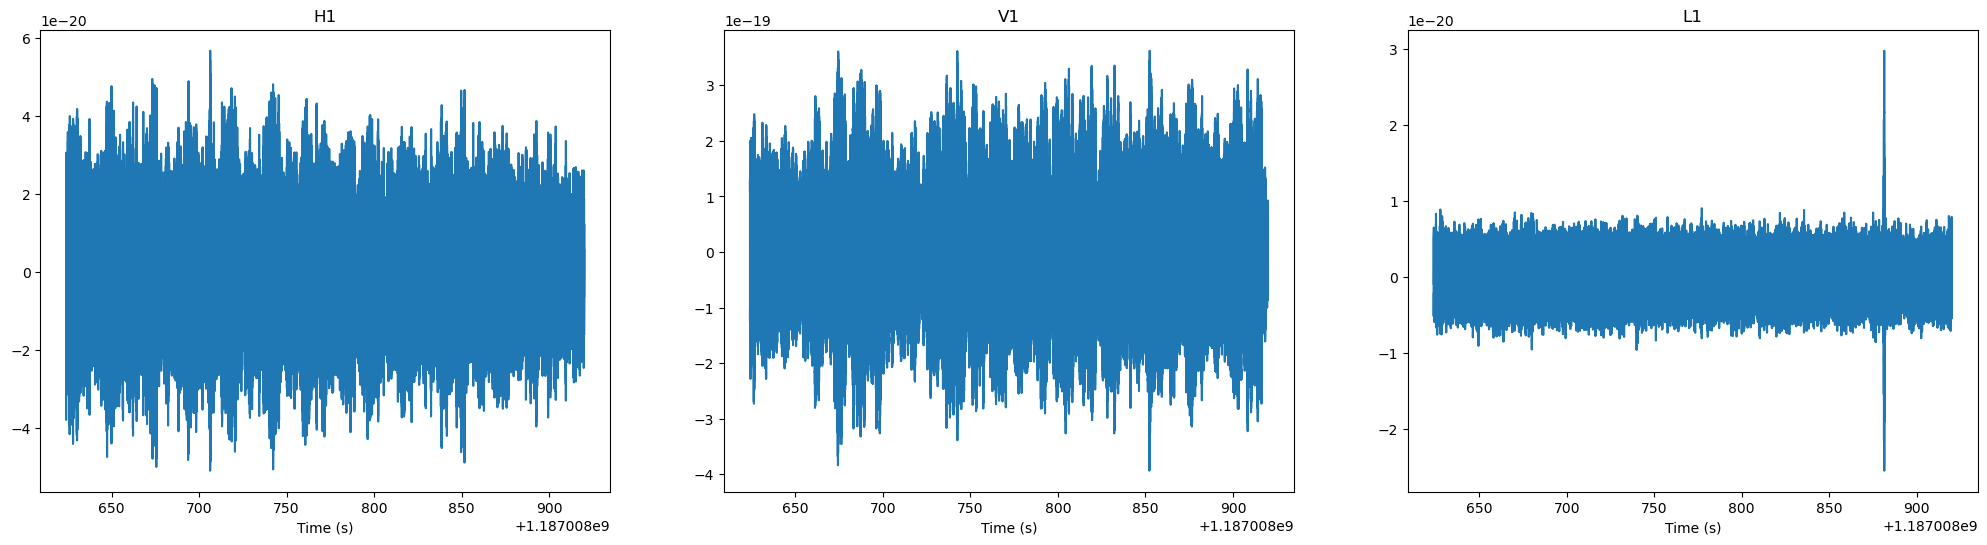

In [8]:
gw170817_highpass_croped = {}

fig, ax = pylab.subplots(1, 3, figsize = (25, 6))

for i, ifo in zip(range(len(ifos)), ifos):
    gw170817_highpass_croped[ifo] = gw170817_highpass_resampled[ifo].crop(2, 2)
    
    ax[i].plot(gw170817_highpass_croped[ifo].sample_times, gw170817_highpass_croped[ifo])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_title(ifo)

pylab.show()

# Power Spectral Density

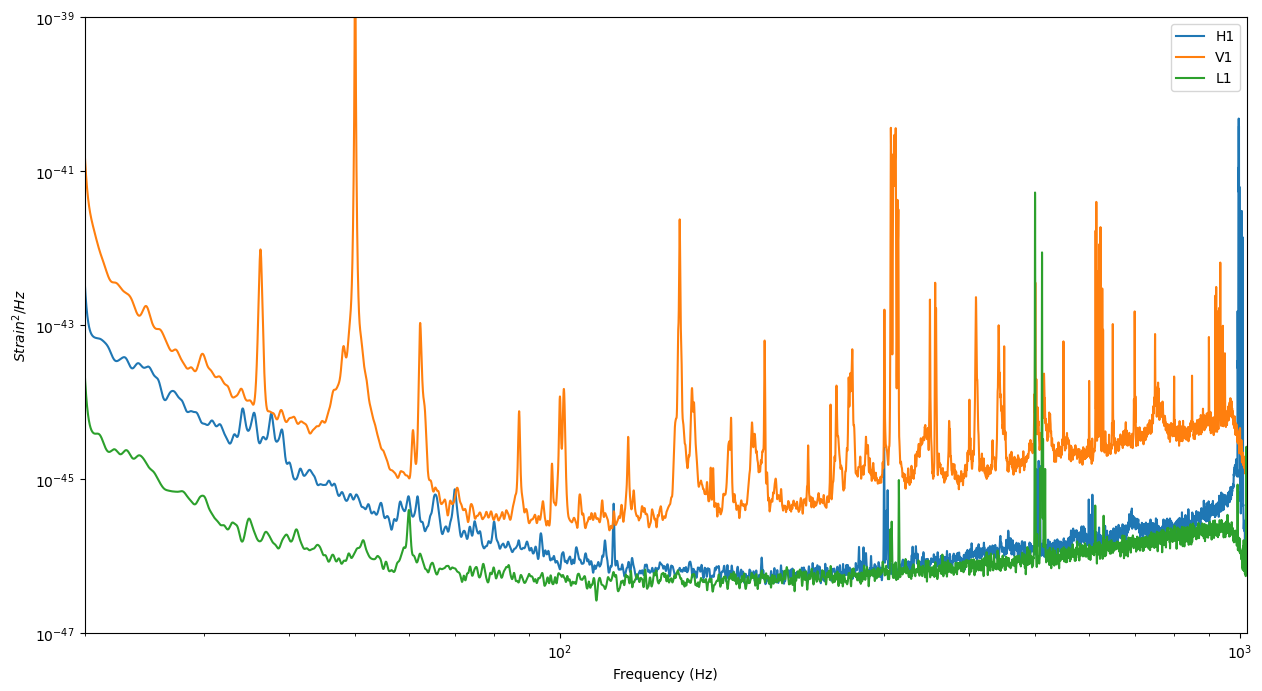

In [9]:
gw170817_interpolate = {}
gw170817_psd = {}

pylab.figure(figsize = (15, 8))

for ifo in ifos:
    
    # Limiting the time around the signal
    gw170817_highpass_resampled[ifo] = gw170817_highpass_resampled[ifo].time_slice(merger_gw170817.time - 112, merger_gw170817.time + 16)
    
    # Convert to a frequency series by taking the data's FFT and storing it in gw170817 series
    gw170817[ifo] = gw170817_highpass_resampled[ifo].to_frequencyseries()
    
    # Interpolate: Process of estimating the a new PSD value at a frequency that is not explicitly included in the original PSD.
    # Offers high resolution (provides more detailed information about the freq content in the signal), reduces noise and statistical fluctutations in the data.
    gw170817_interpolate[ifo] = interpolate(gw170817_highpass_resampled[ifo].psd(4), gw170817_highpass_resampled[ifo].delta_f)
    
    # inverse_spectrum_truncation: It is used to mitigate the effects of non-stationary noise in the data.
    gw170817_psd[ifo] = inverse_spectrum_truncation(gw170817_interpolate[ifo], int(4 * gw170817_interpolate[ifo].sample_rate), trunc_method = "hann", low_frequency_cutoff = 20.0)
    
    psds[ifo] = gw170817_psd[ifo]
    
    pylab.loglog(gw170817_psd[ifo].sample_frequencies, gw170817_psd[ifo], label = ifo)
    pylab.ylabel('$Strain^2 / Hz$')
    pylab.xlabel('Frequency (Hz)')
    
    pylab.ylim(1e-47, 1e-39)
    pylab.xlim(20, 1024)
    
    pylab.legend()

pylab.show()

**Spikes in the above graph indicates the presence of noise at specific frequencies for each detectors.**

**Not all peaks in the above graph are due to noise. Some may due to presence of gravitational waves.**

# Visualizing the Gravitational Wave

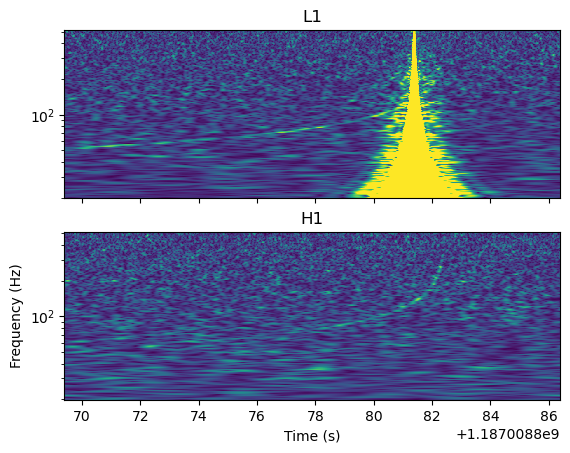

In [10]:
import matplotlib.pyplot as pp
import pycbc.catalog


m = pycbc.catalog.Merger("GW170817", source='gwtc-1')


fig, axs = pp.subplots(2, 1, sharex=True, sharey=True)

for ifo, ax in zip(["L1", "H1"], axs):
    pp.sca(ax)
    pp.title(ifo)
    
    # Retreive data around the BNS merger
    ts = m.strain(ifo).time_slice(m.time - 15, m.time + 6)

    # Whiten the data with a 4s filter
    white = ts.whiten(4, 4)

    times, freqs, power = white.qtransform(.01, logfsteps=200,
                                        qrange=(110, 110),
                                        frange=(20, 512))
    pp.pcolormesh(times, freqs, power**0.5, vmax=5)

pp.yscale('log')
pp.ylabel("Frequency (Hz)")
pp.xlabel("Time (s)")
pp.show()

# Single Template Model

**It is a search method that uses a single pre-defined waveform template to match against our data.**

**Model requires a specific set of data products:<br><li>Dictionary of frequency-domain data</li><li>Dictionary of Power Spectral Density estimates</li><li>Low frequency cutoff to use for internal filtering in the model.</li>**

## Dictionary of frequency-domain data

In [11]:
gw170817

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d41e99c10>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d41f885b0>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d44191c70>}

## Dictionary of Power Spectral Density

In [12]:
psds

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d41f6cfd0>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d43918880>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f5d4416ee20>}

# Retrieving mass values

In [13]:
import h5py

fp = h5py.File("4-OGC_small.hdf", "r")
names = fp["name"][:].astype(str)

# idx is the row index corresponding to the trigger associated with GW170817
idx = np.where(names == "170817_124104")[0][0]

# Values of Masses, Spins, and Coalescence time
print("Mass 1: ", fp["mass1"][idx], "\nMass 2: ", fp["mass2"][idx], "\nCoalescence time:", fp["time"][idx])

Mass 1:  1.5210252 
Mass 2:  1.246091 
Coalescence time: 1187008882.4453125


# Estimating the skylocations of GW170817 for fixed masses

## Determining sky locations using all parameters

### Setting up the prior distribution model

In [14]:
static_parameters = {
    'mass1': 1.5210252,
    'mass2': 1.246091,
    'f_lower': 25.0,
    'tc': 1187008882.4453125,
    'approximant': 'TaylorF2',
    'polarization': 0
}

variable_parameters = (
    'distance',
    'inclination',
    'ra',
    'dec'
)

prior = JointDistribution(variable_parameters, 
                          Uniform(inclination = (2, np.pi),
                                  distance = (20, 50)),
                          UniformSky())

### Setting up the model

In [15]:
model = models.SingleTemplate(variable_params = variable_parameters, data = copy.deepcopy(gw170817), low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                              sample_rate = 8192, psds = psds, static_params = static_parameters, prior = prior)

smpl = sampler.EmceePTSampler(model = model, ntemps = 3, nwalkers = 200, nprocesses = 8)

### Setting up the initial values

In [16]:
_ = smpl.set_p0()

### Running the sampler

In [17]:
smpl.run_mcmc(niterations = 400)

### Plotting the Loglikelihood of ra and dec

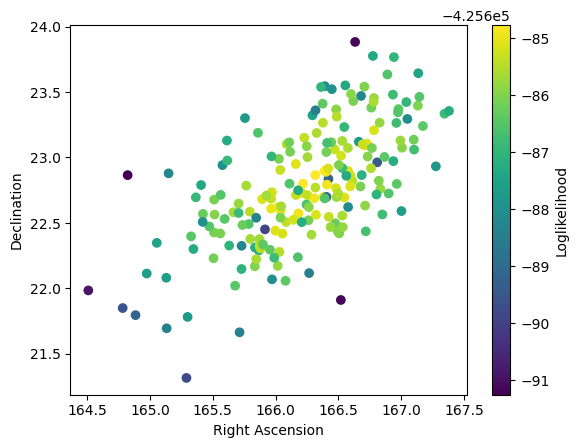

In [18]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Converting radians to degrees
ra_degrees = np.rad2deg(smpl.samples['ra'])
dec_degrees = np.rad2deg(smpl.samples['dec'])

pylab.scatter(ra_degrees[0,:,-1],
              dec_degrees[0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')

c = pylab.colorbar()
c.set_label('Loglikelihood')

pylab.show()

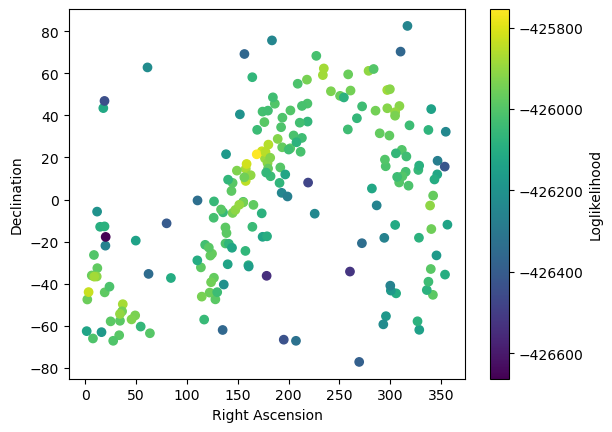

In [46]:
# We'll plot the initial position of the walkers
fig = pylab.figure(11)

# Converting radians to degrees
ra_degrees = np.rad2deg(smpl.samples['ra'])
dec_degrees = np.rad2deg(smpl.samples['dec'])

a = pylab.scatter(ra_degrees[0, :, 0], dec_degrees[0, :, 0],
                  c=lik[0,:,0])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')

# pylab.xlim(120, 180)

c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = np.array([ra_degrees[0,:,i], dec_degrees[0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(ra_degrees[0,0,:])
ani = animation.FuncAnimation(fig, animate, frames = nsamples,
                              interval=200, blit=True)

#### Convergence

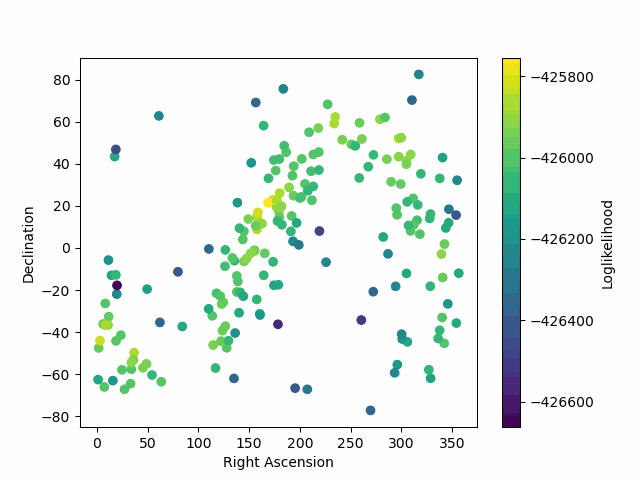

In [47]:
ani.save('GW170817_ra_dec_all_parameters.gif', writer=PillowWriter(fps=5))
with open('GW170817_ra_dec_all_parameters.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### Plotting the Loglikelihood of distance and inclination

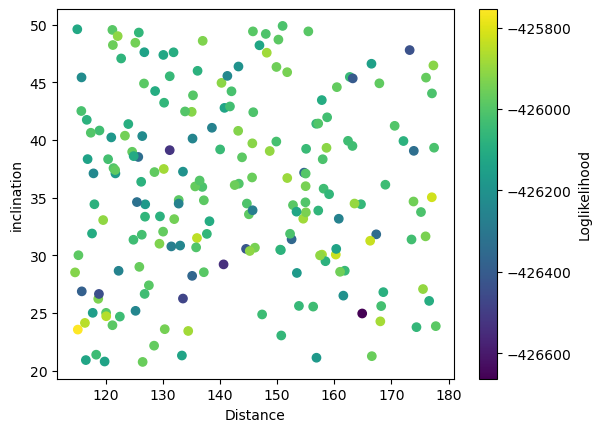

In [21]:
# We'll plot the initial position of the walkers
fig = pylab.figure(11)

# Converting radians to degrees
inclination_degrees = np.rad2deg(smpl.samples['inclination'])
distance = smpl.samples['distance']

a = pylab.scatter(inclination_degrees[0, :, 0], distance[0, :, 0],
                  c=lik[0,:,0])
pylab.xlabel('Distance')
pylab.ylabel('inclination')
c = pylab.colorbar()
c.set_label('Loglikelihood')

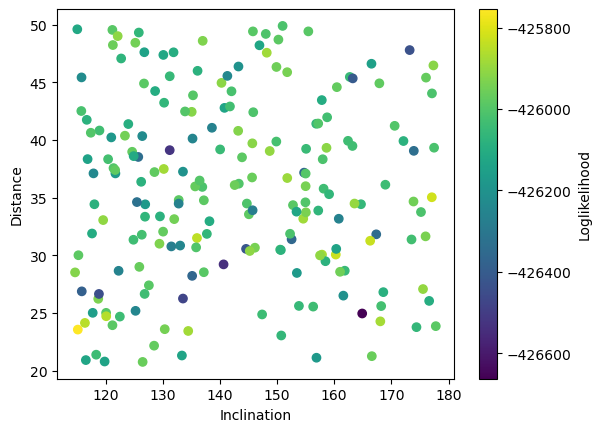

In [32]:
# We'll plot the initial position of the walkers
fig = pylab.figure(11)

# Converting radians to degrees
inclination_degrees = np.rad2deg(smpl.samples['inclination'])
distance = smpl.samples['distance']

a = pylab.scatter(inclination_degrees[0, :, 0], distance[0, :, 0],
                  c=lik[0,:,0])
pylab.xlabel('Inclination')
pylab.ylabel('Distance')

c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = np.array([inclination_degrees[0,:,i], distance[0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(distance[0,0,:])
ani = animation.FuncAnimation(fig, animate, frames = nsamples,
                              interval=200, blit=True)

#### Convergence

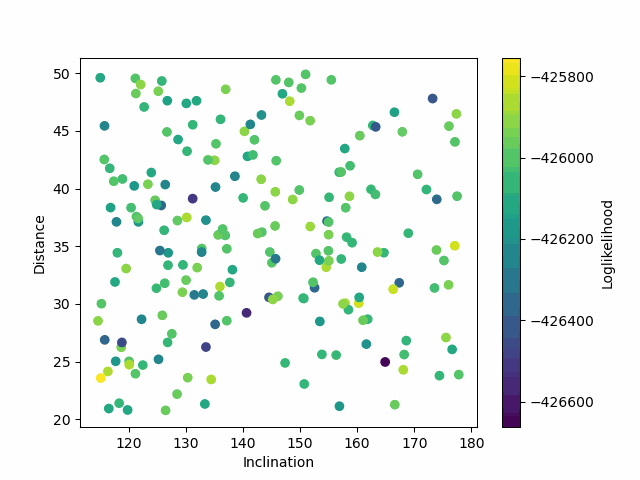

In [33]:
ani.save('GW170817_inc_dist_all_parameters.gif', writer=PillowWriter(fps=5))
with open('GW170817_inc_dist_all_parameters.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### Density Plot

#### ra and dec

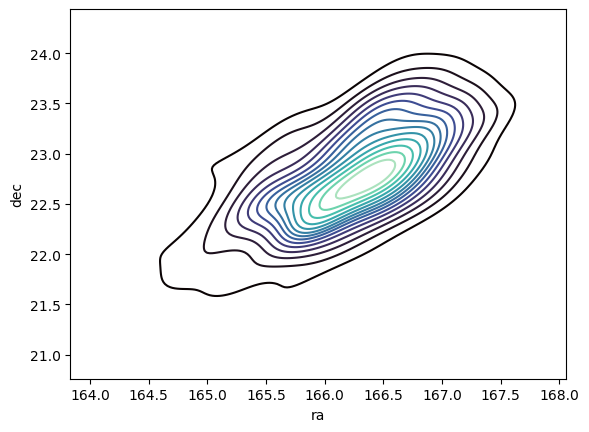

In [22]:
x = ra_degrees[0, :, -1]
y = dec_degrees[0, :, -1]

data = pd.DataFrame({'ra': x, 'dec': y})

sns.kdeplot(x=data['ra'], y=data['dec'], cmap="mako", levels = 15)

pylab.show()

#### inc and dist

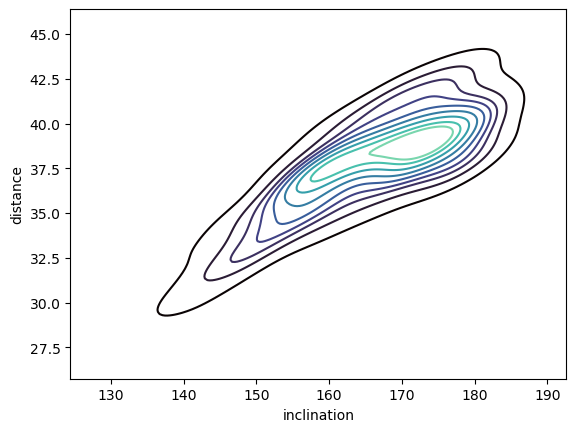

In [35]:
x = inclination_degrees[0, :, -1]
y = distance[0, :, -1]

data = pd.DataFrame({'inclination': x, 'distance': y})

sns.kdeplot(x=data['inclination'], y=data['distance'], cmap="mako", levels = 10)

pylab.show()

## Determining sky locations by making inclination = 0

In [ ]:
static_parameters = {
    'mass1': 1.5210252,
    'mass2': 1.246091,
    'f_lower': 25.0,
    'tc': 1187008882.4453125,
    'approximant': 'TaylorF2',
    'polarization': 0,
    'inclination': 0
}

variable_parameters = (
    'distance',
    'ra',
    'dec'
)

prior = JointDistribution(variable_parameters, 
                          Uniform(distance = (20, 50)),
                          UniformSky())

# Setting up the model
model = models.SingleTemplate(variable_params = variable_parameters, data = copy.deepcopy(gw170817), low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                              sample_rate = 8192, psds = psds, static_params = static_parameters, prior = prior)

# Setting up the sampler
smpl = sampler.EmceePTSampler(model = model, ntemps = 3, nwalkers = 200, nprocesses = 8)

# Setting up the initial values
_ = smpl.set_p0()

# Running the sampler
smpl.run_mcmc(niterations = 400)

### Plotting the LogLikelihood

In [ ]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Converting radians to degrees
ra_degrees = np.rad2deg(smpl.samples['ra'])
dec_degrees = np.rad2deg(smpl.samples['dec'])

pylab.scatter(ra_degrees[0,:,-1],
              dec_degrees[0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')

c = pylab.colorbar()
c.set_label('Loglikelihood')

pylab.show()

### Convergence

In [ ]:
ani.save('GW170817_FixedMasses.gif', writer=PillowWriter(fps=5))
with open('GW170817_FixedMasses.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### Density Plot

In [ ]:
x = ra_degrees[0, :, -1]
y = dec_degrees[0, :, -1]

data = pd.DataFrame({'ra': x, 'dec': y})

sns.kdeplot(x=data['ra'], y=data['dec'], cmap="mako", levels = 15)

pylab.show()